In [13]:
%load_ext autoreload
%autoreload 2
import os
import sys
from pathlib import Path
import joblib

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
from src.Bayesian import *
from src.Bayesian.problems.config import config_fgt
from src.Bayesian.problems import *
from src.Bayesian.utils.optimizer import Optimizer
from src.Bayesian.utils.model_evaluation import ModelEval

In [21]:
# Example module config
module_config = {
    "perception": (BasePerception, {}),
    "memory": (BaseMemory, {
        "personal_memory_range": {
            "gamma": (0.05, 1.0),
            "w0": (0.075, 0.15)
        },
        "param_resolution": 20
    }),
    "cluster": (PartitionCluster, {
        "transition_spec": [("random_4", "top_posterior"),
                            ("opp_random_4", "random")]
    })
}
optimizer = Optimizer(module_config, n_jobs=10)

# 导入数据
processed_path = Path(project_root) / 'data' / 'processed'
optimizer.prepare_data(processed_path / 'Task2_processed.csv')

In [26]:
iSub = 1
results = optimizer.optimize_params_with_subs_parallel(
    config_fgt, [iSub], 16, 1, 3)

Processing tasks:   0%|                                                     | 0/400 [00:00<?, ?it/s]

Computing error for params: 100%|██████████| 3/3 [00:00<00:00, 3479.79it/s]


In [ ]:
# save results
result_path = Path(project_root) / 'results' / 'Model_results'
os.makedirs(result_path, exist_ok=True)

optimizer.save_results(results, 'M7_PMH_sub1', result_path)

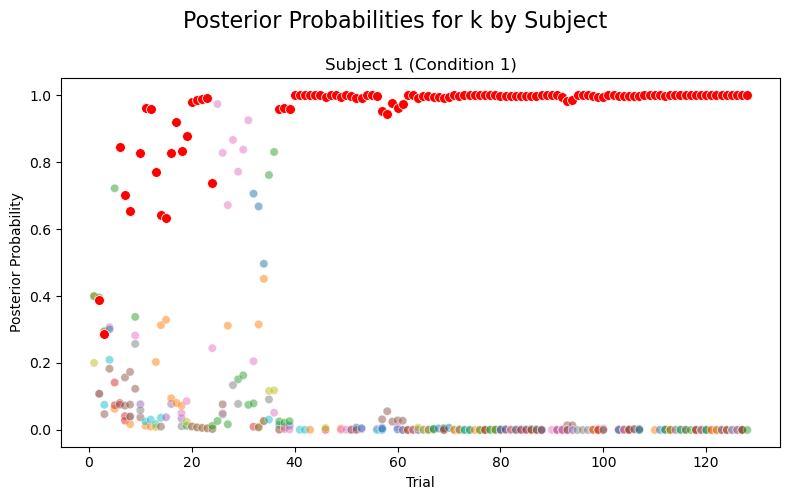

In [5]:
model_eval = ModelEval()
model_eval.plot_posterior_probabilities(results, [iSub])

In [6]:
optimizer.set_results(results)
prediction = optimizer.predict_with_subs_parallel(
    config_fgt, [iSub])

Predicting tasks: 100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 1314.42it/s]

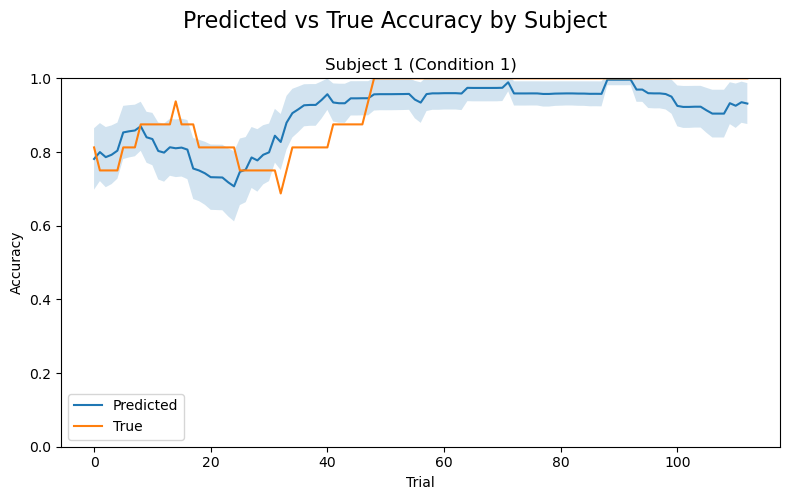

In [7]:
model_eval.plot_accuracy_comparison(prediction, [iSub])

In [8]:
from src.Bayesian.utils.oral_process import Oral_to_coordinate
oral_to_coordinate = Oral_to_coordinate()

learning_data = pd.read_csv(processed_path / 'Task2_processed.csv')
oral_hypo_hits = oral_to_coordinate.get_oral_hypo_hits(learning_data)

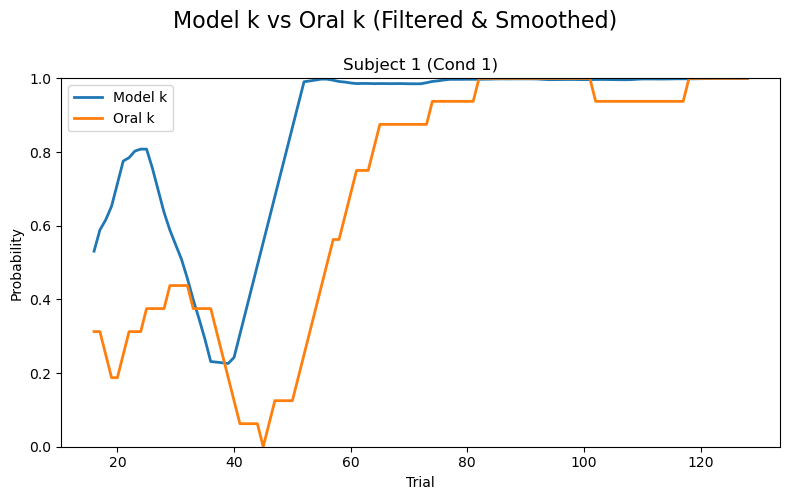

In [9]:
model_eval.plot_k_oral_comparison(results, oral_hypo_hits, [iSub])

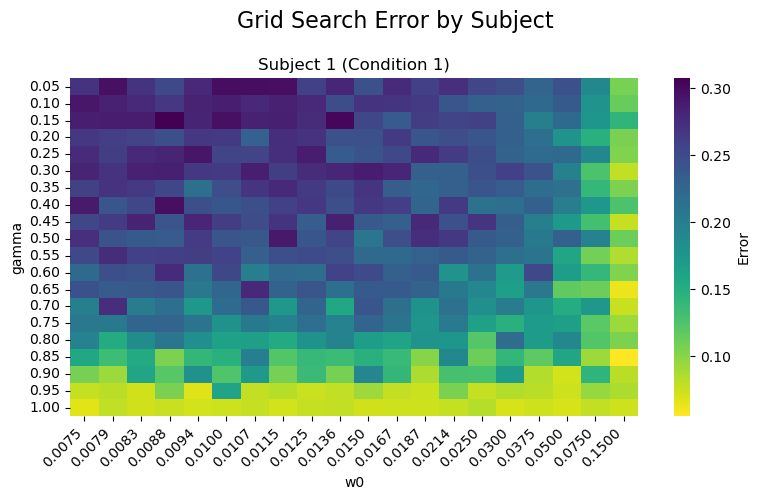

In [12]:
model_eval.plot_error_grids(results, fname=['gamma','w0'])

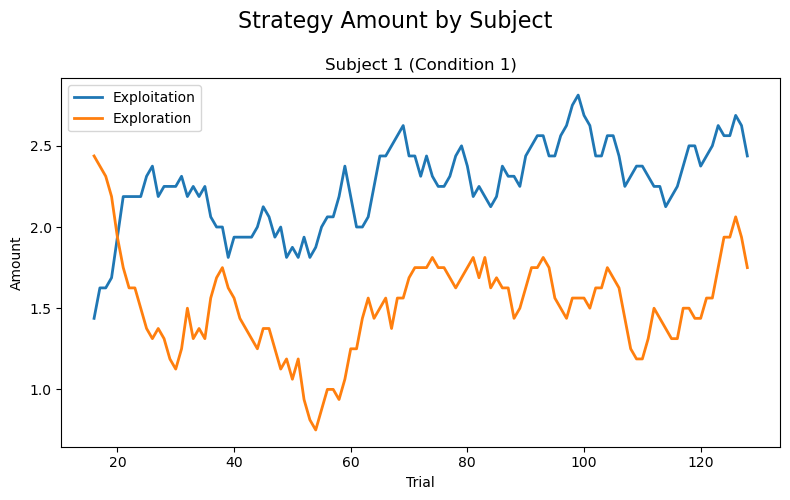

In [13]:
model_eval.plot_cluster_amount(results, 16, [iSub])

## ----

In [ ]:
from src.Bayesian.utils.stream import StreamList
import seaborn as sns
from tqdm import tqdm
from joblib import Parallel, delayed
from tqdm_joblib import tqdm_joblib

In [7]:
model_name = 'M7_PMH'
result_path = Path(project_root) / 'results' / 'Model_results_new' 
results = joblib.load(result_path / f'{model_name}.joblib')

In [ ]:
def compute_single_entry(iSub, p_bin, info, oral_hit):
    p_lower, p_upper = p_bin
    path, n = info['raw_step_results']
    sample_errors = np.array(info['sample_errors'])
    k_special = 0 if oral_hit['condition'] == 1 else 42
    oral_rolling = np.array(oral_hit['rolling_hits'], dtype=float)
    slist = StreamList(path, n)

    sorted_indices = np.argsort(sample_errors)
    low_idx = int(n * p_lower / 100)
    high_idx = int(n * p_upper / 100)
    top_idxs = sorted_indices[low_idx:high_idx]

    acc_errors = [sample_errors[int(i)] for i in top_idxs]

    k_oral_errors = []
    for i in top_idxs:
        traj = slist[int(i)]
        posts = []
        for sr in traj:
            post = sr['hypo_details'].get(k_special, {}).get('post_max', 0.0)
            try:
                posts.append(float(post))
            except Exception:
                posts.append(0.0)
        posts = pd.Series(posts).rolling(window=16, min_periods=16).mean().to_numpy()
        min_len = min(len(posts), len(oral_rolling))
        valid = ~np.isnan(posts[:min_len])
        if valid.sum() > 0:
            err = np.mean(np.abs(posts[:min_len][valid] - oral_rolling[:min_len][valid]))
        else:
            err = np.nan
        k_oral_errors.append(err)

    return {
        'Subject': iSub,
        'Percentile_Bin': f"{p_lower}-{p_upper}",
        'Accuracy_Error_Mean': np.mean(acc_errors),
        'Accuracy_Error_Std': np.std(acc_errors),
        'KOral_Error_Mean': np.nanmean(k_oral_errors),
        'KOral_Error_Std': np.nanstd(k_oral_errors)
    }


def compute_errors_fine_parallel_with_progress(results, oral_hypo_hits,
                                               bin_edges=range(0, 101, 5),
                                               n_jobs=-1):

    tasks, percentile_bins = [], list(zip(bin_edges[:-1], bin_edges[1:]))
    for iSub, info in results.items():
        if iSub not in oral_hypo_hits or 'raw_step_results' not in info:
            continue
        for p_bin in percentile_bins:
            tasks.append((iSub, p_bin, info, oral_hypo_hits[iSub]))

    with tqdm_joblib(tqdm(total=len(tasks),
                          desc="Computing errors",
                          ncols=80)):

        out = Parallel(n_jobs=n_jobs,batch_size=1)(
            delayed(compute_single_entry)(iSub, p_bin, info, oral_hit)
            for iSub, p_bin, info, oral_hit in tasks
        )

    return pd.DataFrame([r for r in out if r is not None])

In [9]:
from src.Bayesian.utils.oral_process import Oral_to_coordinate
oral_to_coordinate = Oral_to_coordinate()

processed_path = Path(project_root) / 'data' / 'processed'
learning_data = pd.read_csv(processed_path / 'Task2_processed.csv')
oral_hypo_hits = oral_to_coordinate.get_oral_hypo_hits(learning_data)

In [ ]:
df_eval = compute_errors_fine_parallel_with_progress(results, oral_hypo_hits, n_jobs=120)

In [15]:
joblib.dump(df_eval, result_path / f'{model_name}_sample_analysis.joblib')

['/home/yangjiong/CategoryLearning_gitcode/results/Model_results_new/M7_PMH_sample_analysis.joblib']

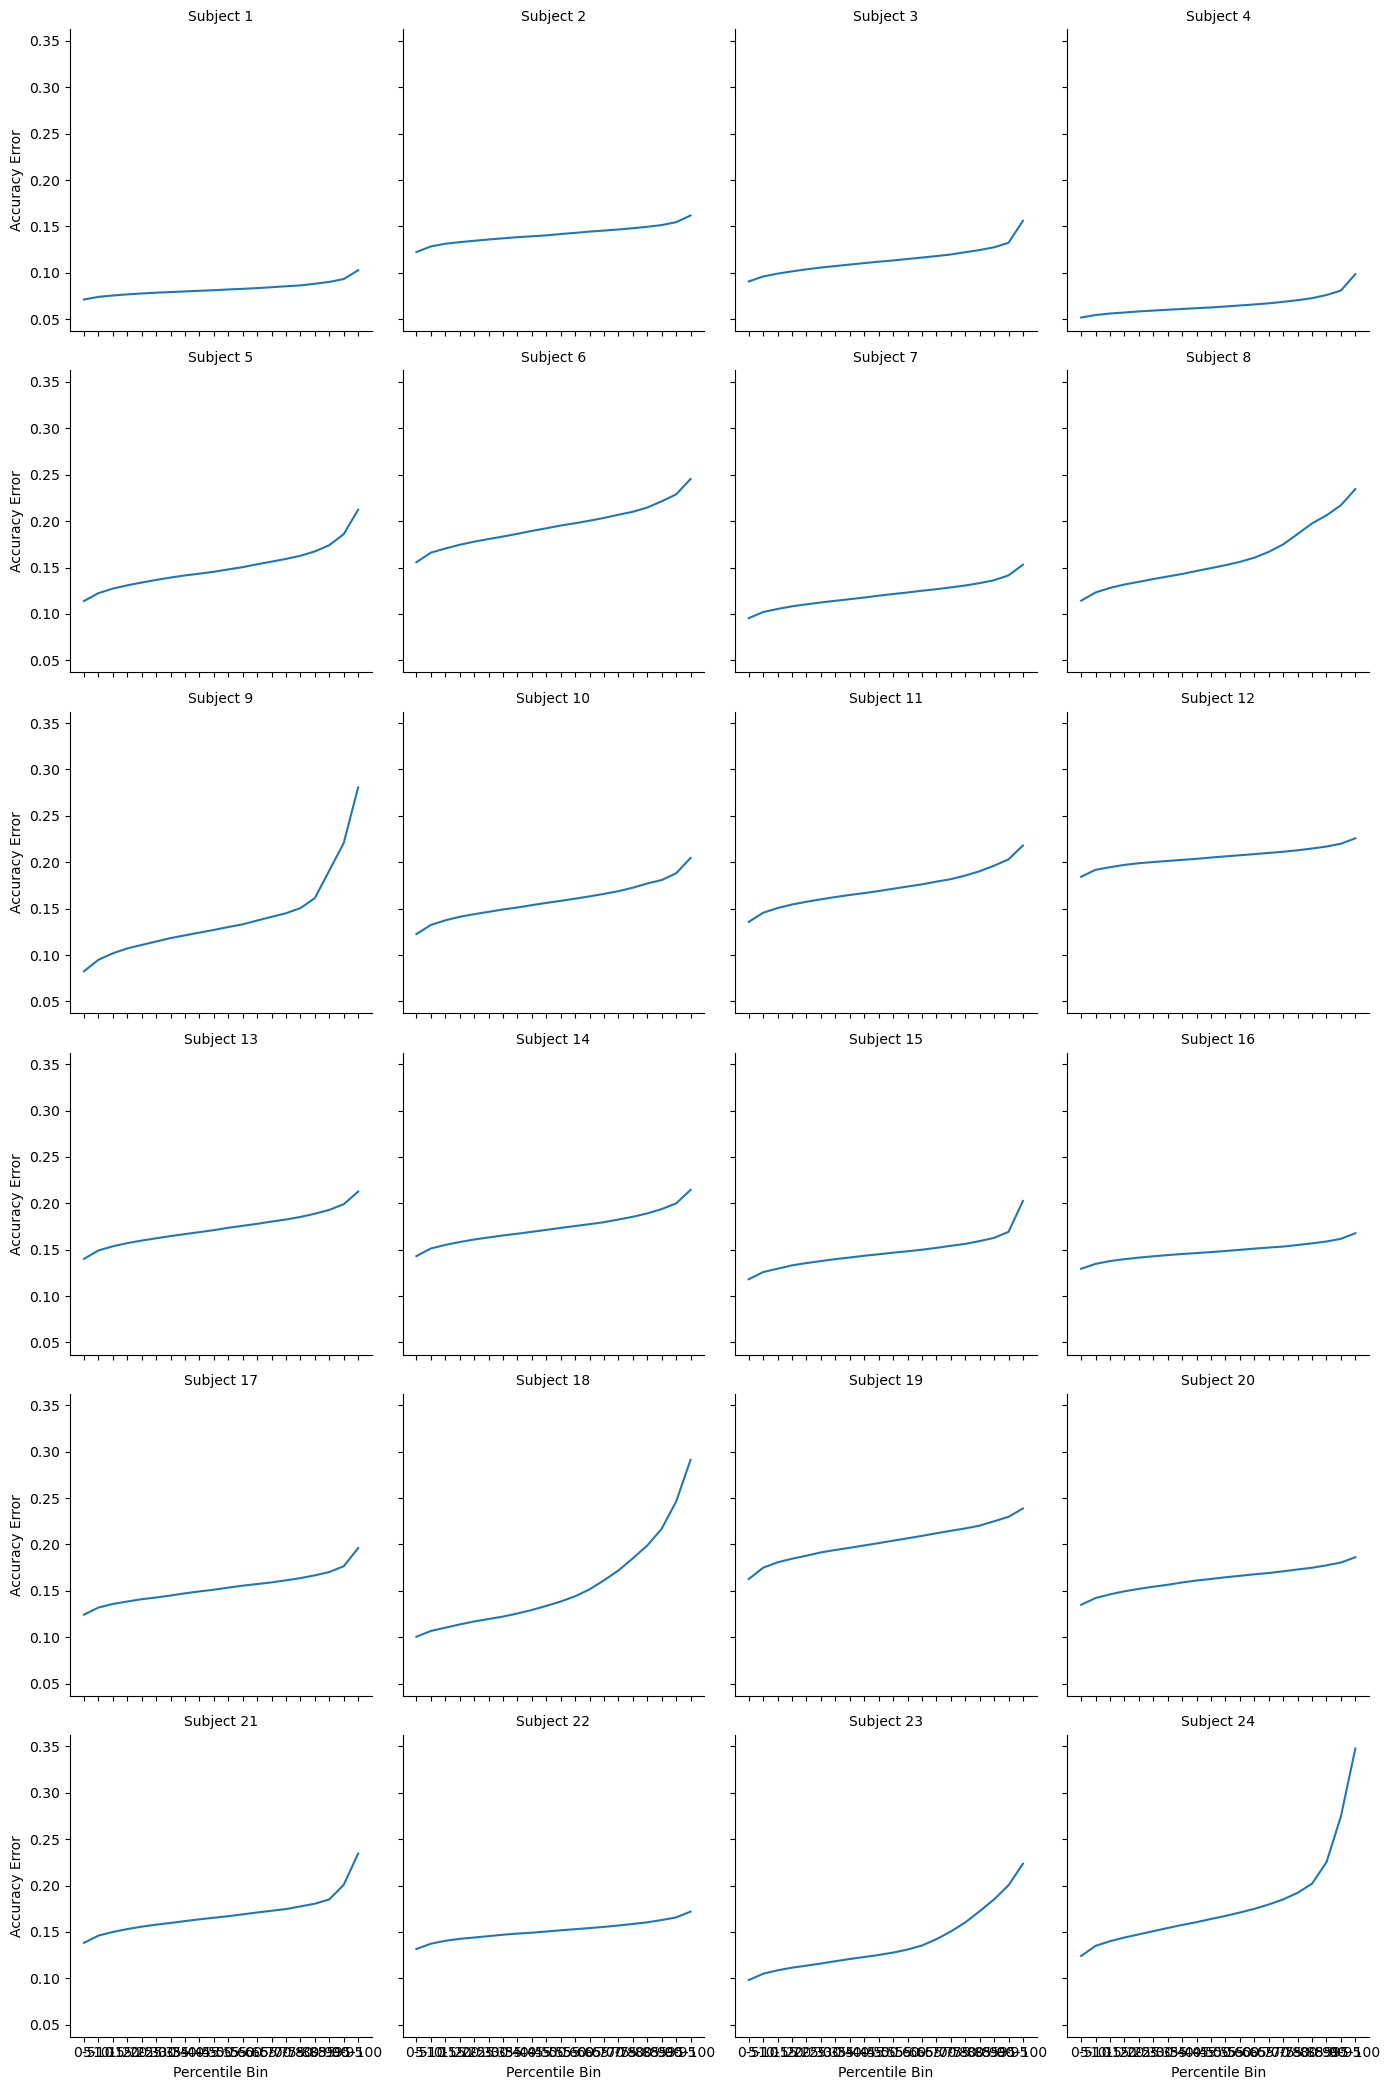

In [23]:
from matplotlib import pyplot as plt

# Accuracy error plot
g1 = sns.FacetGrid(df_eval, col='Subject', col_wrap=4, height=3.5)
g1.map_dataframe(sns.lineplot, x='Percentile_Bin', y='Accuracy_Error')
g1.set_axis_labels("Percentile Bin", "Accuracy Error")
g1.set_titles("Subject {col_name}")
# g1.suptitle("Accuracy Error vs. Top Trajectory Percentile", y=1.02)
plt.tight_layout()

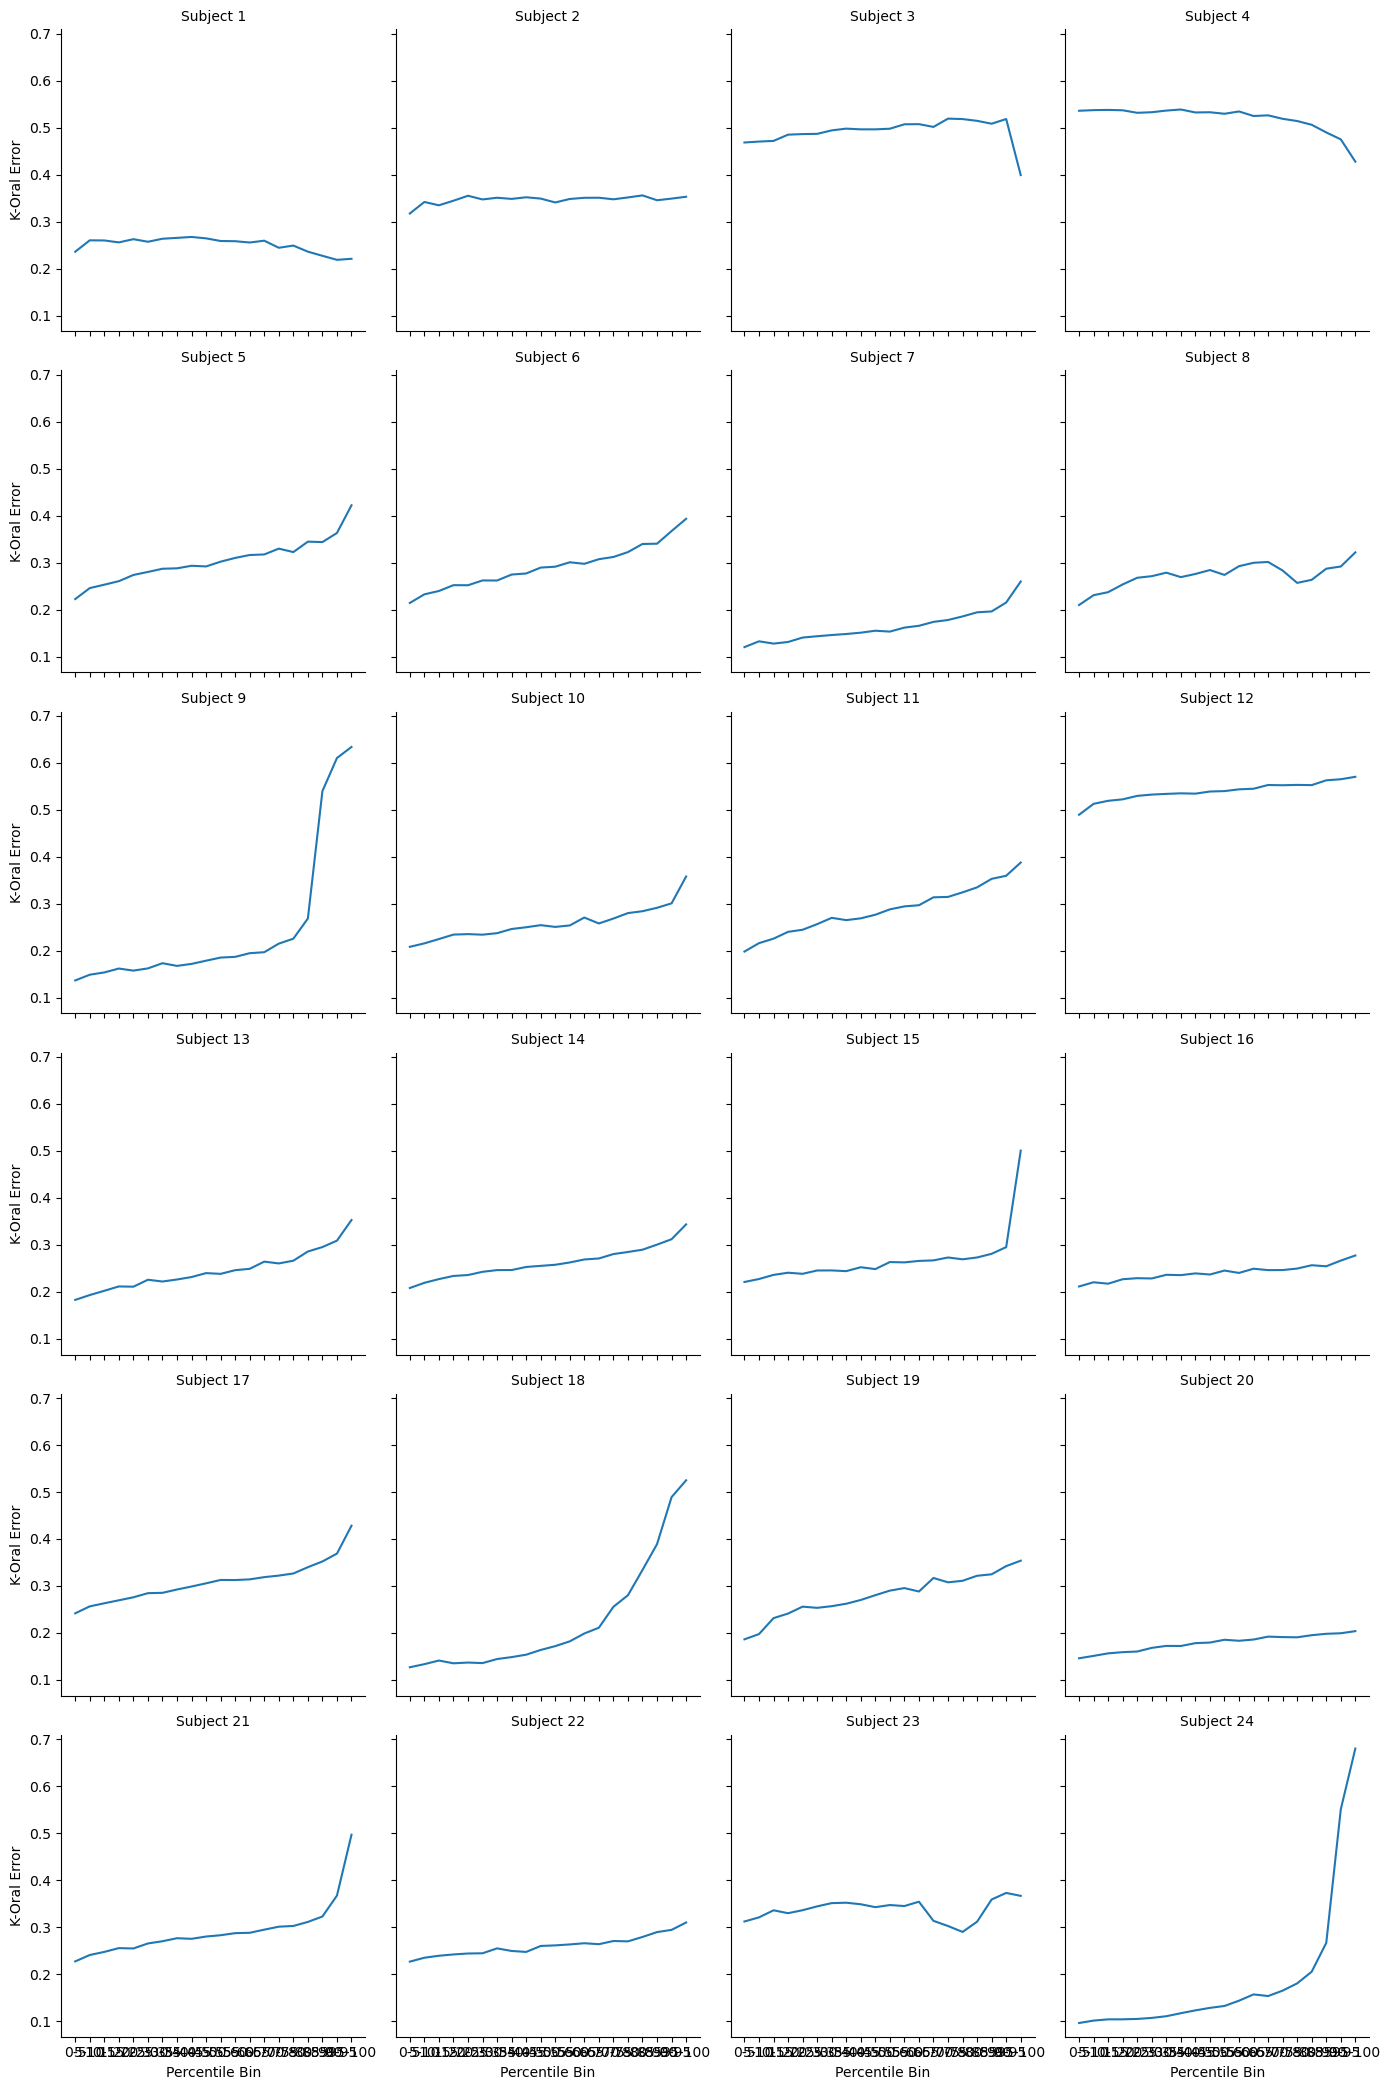

In [24]:
# K-Oral error plot
g2 = sns.FacetGrid(df_eval, col='Subject', col_wrap=4, height=3.5)
g2.map_dataframe(sns.lineplot, x='Percentile_Bin', y='KOral_Error')
g2.set_axis_labels("Percentile Bin", "K-Oral Error")
g2.set_titles("Subject {col_name}")
# g2.suptitle("K-Oral Error vs. Top Trajectory Percentile", y=1.02)
plt.tight_layout()

## ----

In [15]:
from src.Bayesian.utils.stream import StreamList
import seaborn as sns
from tqdm import tqdm
from joblib import Parallel, delayed
from tqdm_joblib import tqdm_joblib

In [16]:
model_name = 'M7_PMH'
result_path = Path(project_root) / 'results' / 'Model_results_new' 
results = joblib.load(result_path / f'{model_name}.joblib')

Computing errors:   0%|                                 | 0/480 [33:19<?, ?it/s]


In [17]:
def compute_single_entry(iSub, p_bin, info, oral_hit):
    p_lower, p_upper = p_bin
    path, n = info['raw_step_results']
    sample_errors = np.array(info['sample_errors'])
    k_special = 0 if oral_hit['condition'] == 1 else 42
    oral_rolling = np.array(oral_hit['rolling_hits'], dtype=float)
    slist = StreamList(path, n)

    # Randomly sample 500 trajectories
    rng = np.random.default_rng(seed=iSub * int(p_lower * 100 + p_upper))  # 保证可复现
    sampled_idxs = rng.choice(n, size=min(500, n), replace=False)
    sampled_errors = sample_errors[sampled_idxs]
    
    sorted_sampled_idxs = sampled_idxs[np.argsort(sampled_errors)]
    low_idx = int(len(sorted_sampled_idxs) * p_lower / 100)
    high_idx = int(len(sorted_sampled_idxs) * p_upper / 100)
    top_idxs = sorted_sampled_idxs[low_idx:high_idx]

    acc_errors = [sample_errors[int(i)] for i in top_idxs]

    k_oral_errors = []
    for i in top_idxs:
        traj = slist[int(i)]
        posts = []
        for sr in traj:
            post = sr['hypo_details'].get(k_special, {}).get('post_max', 0.0)
            try:
                posts.append(float(post))
            except Exception:
                posts.append(0.0)
        posts = pd.Series(posts).rolling(window=16, min_periods=16).mean().to_numpy()
        min_len = min(len(posts), len(oral_rolling))
        valid = ~np.isnan(posts[:min_len])
        if valid.sum() > 0:
            err = np.mean(np.abs(posts[:min_len][valid] - oral_rolling[:min_len][valid]))
        else:
            err = np.nan
        k_oral_errors.append(err)

    return {
        'Subject': iSub,
        'Percentile_Bin': f"{p_lower}-{p_upper}",
        'Accuracy_Error_Mean': np.mean(acc_errors),
        'Accuracy_Error_Std': np.std(acc_errors),
        'KOral_Error_Mean': np.nanmean(k_oral_errors),
        'KOral_Error_Std': np.nanstd(k_oral_errors)
    }


def compute_errors_fine_parallel_with_progress(results, oral_hypo_hits,
                                               bin_edges=range(0, 101, 5),
                                               n_jobs=-1):

    tasks, percentile_bins = [], list(zip(bin_edges[:-1], bin_edges[1:]))
    for iSub, info in results.items():
        if iSub not in oral_hypo_hits or 'raw_step_results' not in info:
            continue
        for p_bin in percentile_bins:
            tasks.append((iSub, p_bin, info, oral_hypo_hits[iSub]))

    with tqdm_joblib(tqdm(total=len(tasks),
                          desc="Computing errors",
                          ncols=80)):

        out = Parallel(n_jobs=n_jobs,batch_size=1)(
            delayed(compute_single_entry)(iSub, p_bin, info, oral_hit)
            for iSub, p_bin, info, oral_hit in tasks
        )

    return pd.DataFrame([r for r in out if r is not None])

In [18]:
from src.Bayesian.utils.oral_process import Oral_to_coordinate
oral_to_coordinate = Oral_to_coordinate()

processed_path = Path(project_root) / 'data' / 'processed'
learning_data = pd.read_csv(processed_path / 'Task2_processed.csv')
oral_hypo_hits = oral_to_coordinate.get_oral_hypo_hits(learning_data)

In [ ]:
df_eval_500 = compute_errors_fine_parallel_with_progress(results, oral_hypo_hits, n_jobs=120)

In [8]:
joblib.dump(df_eval_500, result_path / f'{model_name}_sample_analysis_500.joblib')

['/home/yangjiong/CategoryLearning_gitcode/results/Model_results_new/M7_PMH_sample_analysis_500.joblib']

In [ ]:
from matplotlib import pyplot as plt

# Accuracy error plot
g1 = sns.FacetGrid(df_eval_500, col='Subject', col_wrap=4, height=3.5)
g1.map_dataframe(sns.lineplot, x='Percentile_Bin', y='Accuracy_Error')
g1.set_axis_labels("Percentile Bin", "Accuracy Error")
g1.set_titles("Subject {col_name}")
# g1.suptitle("Accuracy Error vs. Top Trajectory Percentile", y=1.02)
plt.tight_layout()

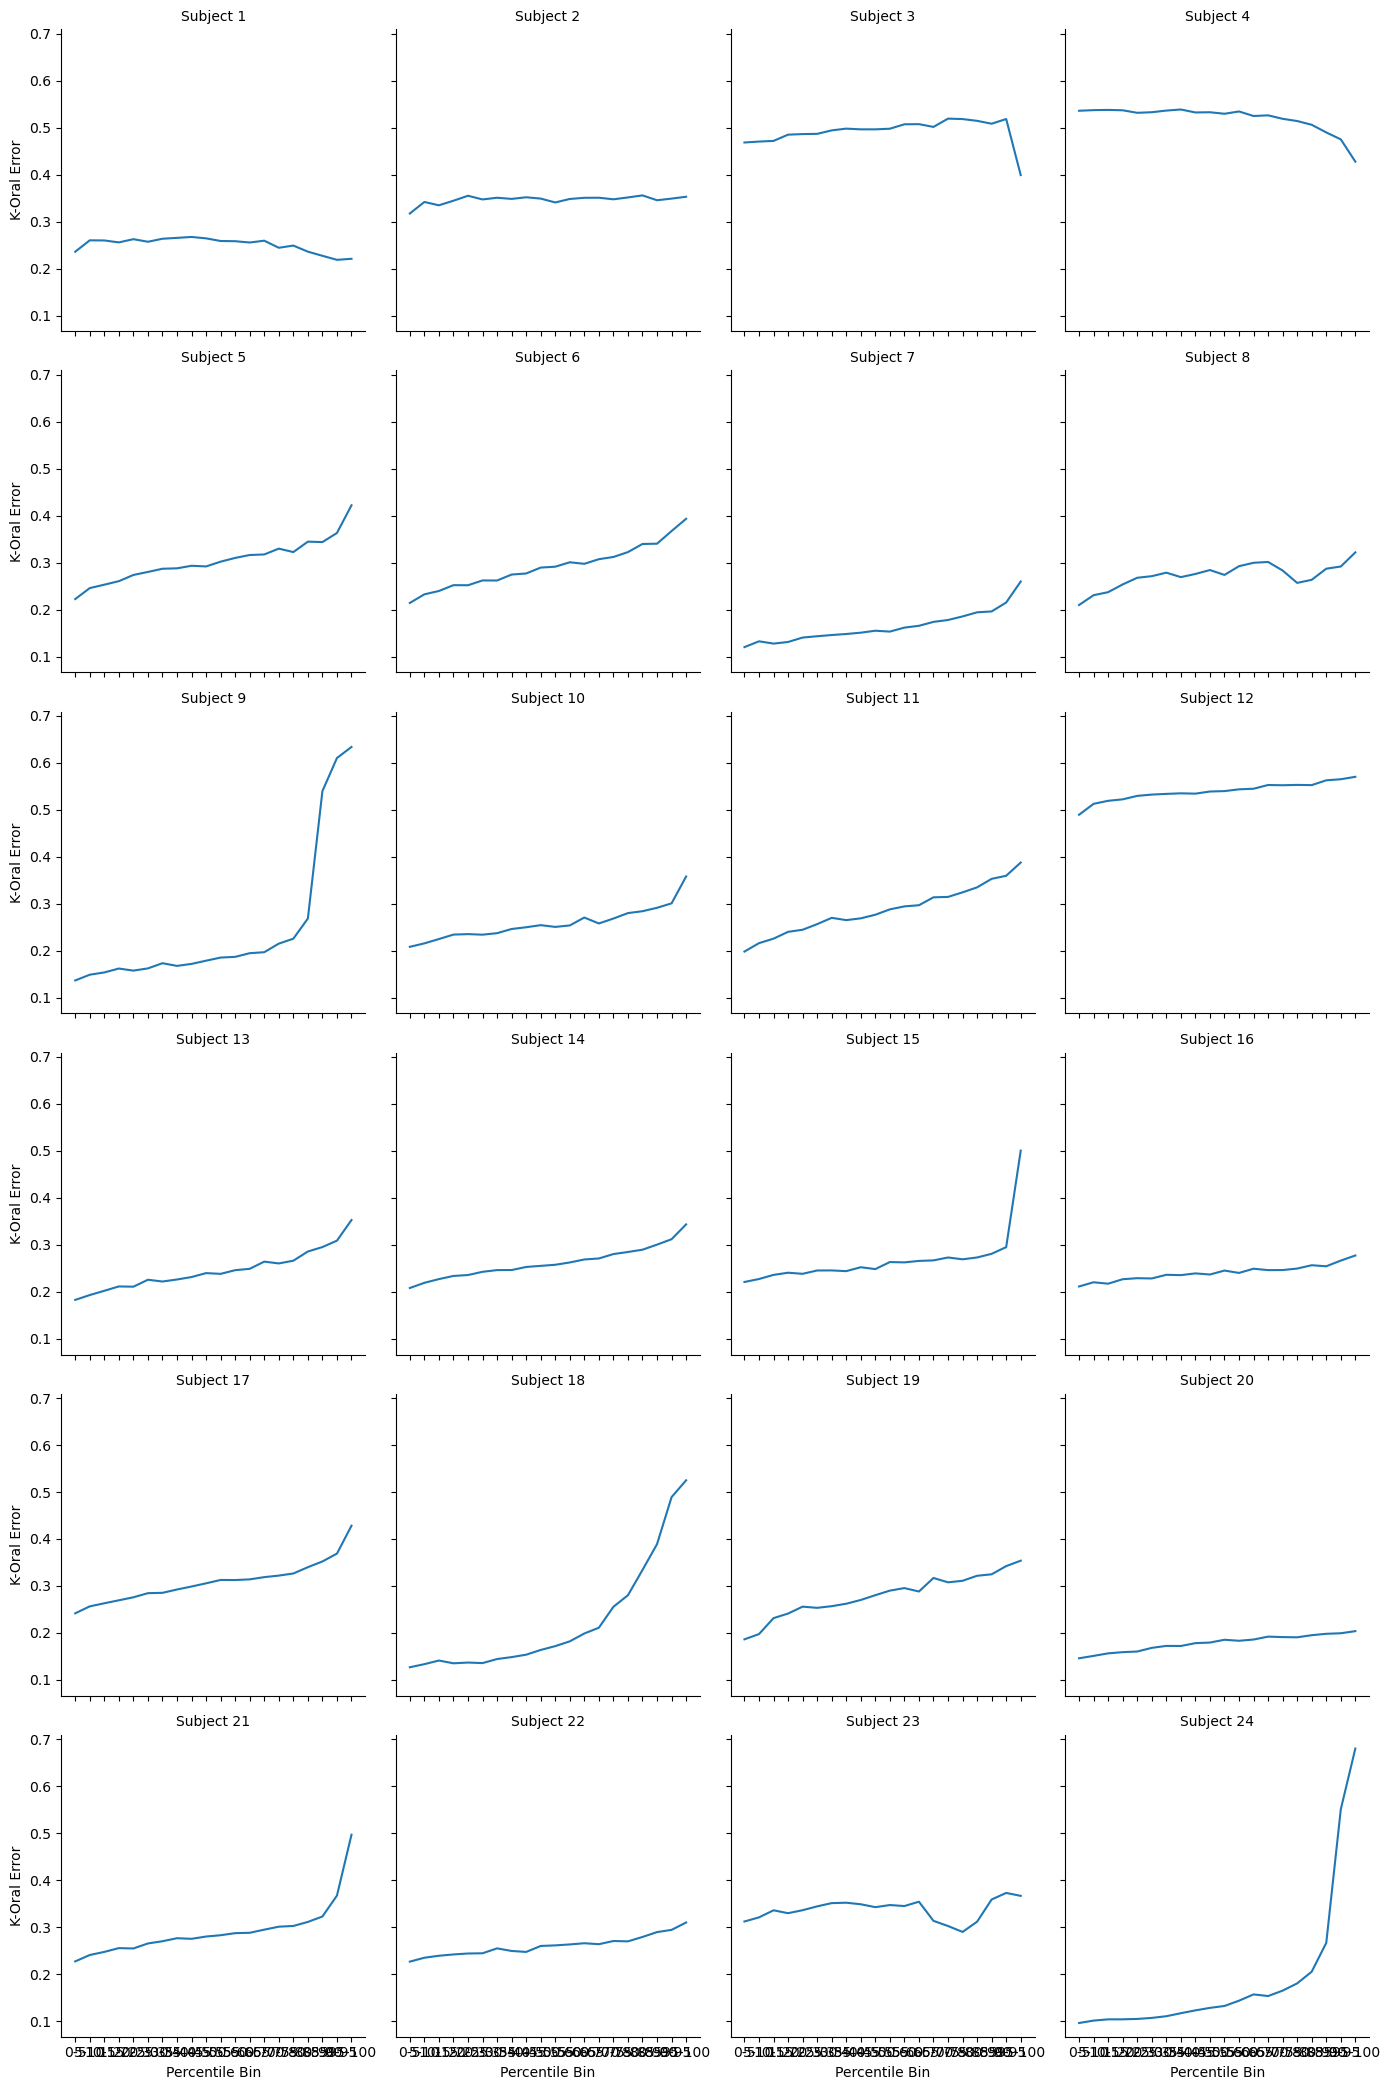

In [ ]:
# K-Oral error plot
g2 = sns.FacetGrid(df_eval, col='Subject', col_wrap=4, height=3.5)
g2.map_dataframe(sns.lineplot, x='Percentile_Bin', y='KOral_Error')
g2.set_axis_labels("Percentile Bin", "K-Oral Error")
g2.set_titles("Subject {col_name}")
# g2.suptitle("K-Oral Error vs. Top Trajectory Percentile", y=1.02)
plt.tight_layout()